In [6]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [7]:
jsons = {}
complaint_glob = "/scr/BEHAVIOR-1K/asset_pipeline/cad/*/*/complaints.json"
for fn in glob.glob(complaint_glob):
    fn = pathlib.Path(fn)
    with open(fn, "r") as f:
        jsons["/".join(fn.parts[-3:-1])] = json.load(f)

In [8]:
print(jsons.keys())

dict_keys(['scenes/Beechwood_1_int', 'scenes/office_cubicles_left', 'scenes/Wainscott_1_int', 'scenes/Benevolence_0_int', 'scenes/Rs_garden', 'scenes/hall_train_station', 'scenes/office_large', 'scenes/hotel_suite_large', 'scenes/grocery_store_half_stocked', 'scenes/Ihlen_0_int', 'scenes/commercial_kitchen_fire_extinguisher', 'scenes/Pomaria_0_garden', 'scenes/house_double_floor_upper', 'scenes/restaurant_hotel', 'scenes/public_restroom_white', 'scenes/school_gym', 'scenes/grocery_store_convenience', 'scenes/Merom_0_int', 'scenes/Pomaria_0_int', 'scenes/public_restroom_brown', 'scenes/public_restroom_marble', 'scenes/restaurant_brunch', 'scenes/school_computer_lab_and_infirmary', 'scenes/Pomaria_2_int', 'scenes/restaurant_cafeteria', 'scenes/public_restroom_blue', 'scenes/office_vendor_machine', 'scenes/grocery_store_asian', 'scenes/Rs_int', 'scenes/house_double_floor_lower', 'scenes/Pomaria_1_int', 'scenes/office_cubicles_right', 'scenes/Beechwood_0_int', 'scenes/Benevolence_1_int', '

In [9]:
next(iter(jsons.values()))

[{'object': 'ceilings-ytbprd',
  'complaint': 'ceiling',
  'processed': True,
  'type': 'collision',
  'additional_info': 'Was at least one of the collision mesh candidates acceptable?'}]

In [17]:
import collections
import re

complaints_by_type = collections.defaultdict(list)
complained_objects_by_type = collections.defaultdict(set)
complaint_types_by_object = collections.defaultdict(set)

for j in jsons.values():
    for complaint in j:
        if complaint["processed"]:
            continue
            
        complaint_type = complaint["type"]
        complaints_by_type[complaint_type].append(complaint)
        obj_id = complaint["object"].split("-")[-1]
        complained_objects_by_type[complaint_type].add(obj_id)
        complaint_types_by_object[obj_id].add(complaint_type)


In [11]:
print(complaints_by_type.keys())

dict_keys(['collision', 'centerofmass', 'appearance', 'unknown', 'metalink', 'connectedness', 'structurethickness', 'handle', 'category', 'clothappearance', 'joint', 'structureconnectedness', 'structureunclosed', 'softbody', 'scale', 'substanceness'])


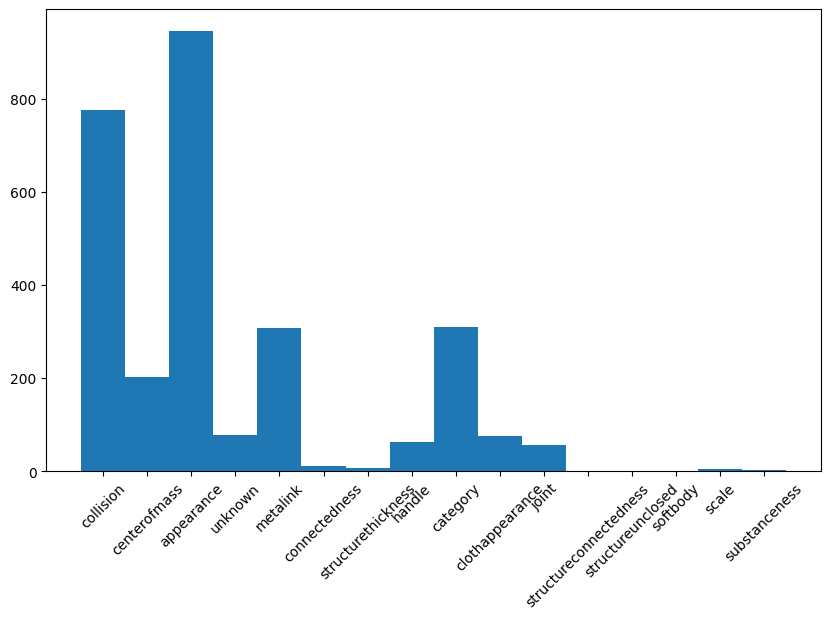

In [12]:
plt.rcParams["figure.figsize"] = (10,6)
labels, values = zip(*[(k, len(v)) for k, v in complaints_by_type.items()])

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=45)
plt.show()

In [14]:
appearance_complaint_objects = complained_objects_by_type["appearance"]

In [15]:
# Load the bad material objects
with open("bad_materials.json", "r") as f:
    bad_materials = set(json.load(f))

print("Objects that are complained about for appearance:", len(appearance_complaint_objects))
print("Objects that have non-Vray materials:", len(bad_materials))
print("Objects that are complained about for appearance and have non-Vray materials:", len(appearance_complaint_objects & bad_materials))
print("Objects that have non-Vray material but not complained about for appearance:", len(bad_materials - appearance_complaint_objects))
print("Objects that are complained about for appearance but have good materials:", len(appearance_complaint_objects - bad_materials))

Objects that are complained about for appearance: 833
Objects that have non-Vray materials: 1394
Objects that are complained about for appearance and have non-Vray materials: 291
Objects that have non-Vray material but not complained about for appearance: 1103
Objects that are complained about for appearance but have good materials: 542


In [25]:
providers = json.loads(pathlib.Path("/scr/BEHAVIOR-1K/asset_pipeline/artifacts/pipeline/object_inventory.json").read_text())["providers"]
objects_by_provider = collections.defaultdict(set)
for obj, provider in providers.items():
    objects_by_provider[provider].add(obj.split("-")[-1])

provider_stats = {}
for provider, objects in objects_by_provider.items():
    provider_complained_objects = objects & set(complaint_types_by_object.keys())
    provider_uncomplained_objects = objects - provider_complained_objects
    provider_appearance_complaint_objects = objects & complained_objects_by_type["appearance"]
    provider_collision_complaint_objects = objects & (complained_objects_by_type["collision"] | complained_objects_by_type["handle"])
    provider_other_complaint_objects = provider_complained_objects - provider_appearance_complaint_objects - provider_collision_complaint_objects

    # We want to make sure that uncomplained + appearance + collision + other = total. To do this, we want to create a "multiple" complaint
    # category, and remove the multiple-complaint objects from each of the separate lists.
    # This is a bit of a hack, but it works.
    complaint_count_per_object = collections.Counter()
    complaint_count_per_object.update(provider_appearance_complaint_objects)
    complaint_count_per_object.update(provider_collision_complaint_objects)
    complaint_count_per_object.update(provider_other_complaint_objects)
    provider_multiple_complaint_objects = set(
        obj for obj, count in complaint_count_per_object.items() if count > 1
    )
    provider_appearance_complaint_objects -= provider_multiple_complaint_objects
    provider_collision_complaint_objects -= provider_multiple_complaint_objects
    provider_other_complaint_objects -= provider_multiple_complaint_objects

    provider_stats[provider] = {
        "uncomplained_objects": len(provider_uncomplained_objects),
        "appearance_complaint_objects": len(provider_appearance_complaint_objects),
        "collision_complaint_objects": len(provider_collision_complaint_objects),
        "multiple_complaint_objects": len(provider_multiple_complaint_objects),
        "other_complaint_objects": len(provider_other_complaint_objects),
        "total": len(objects),
    }

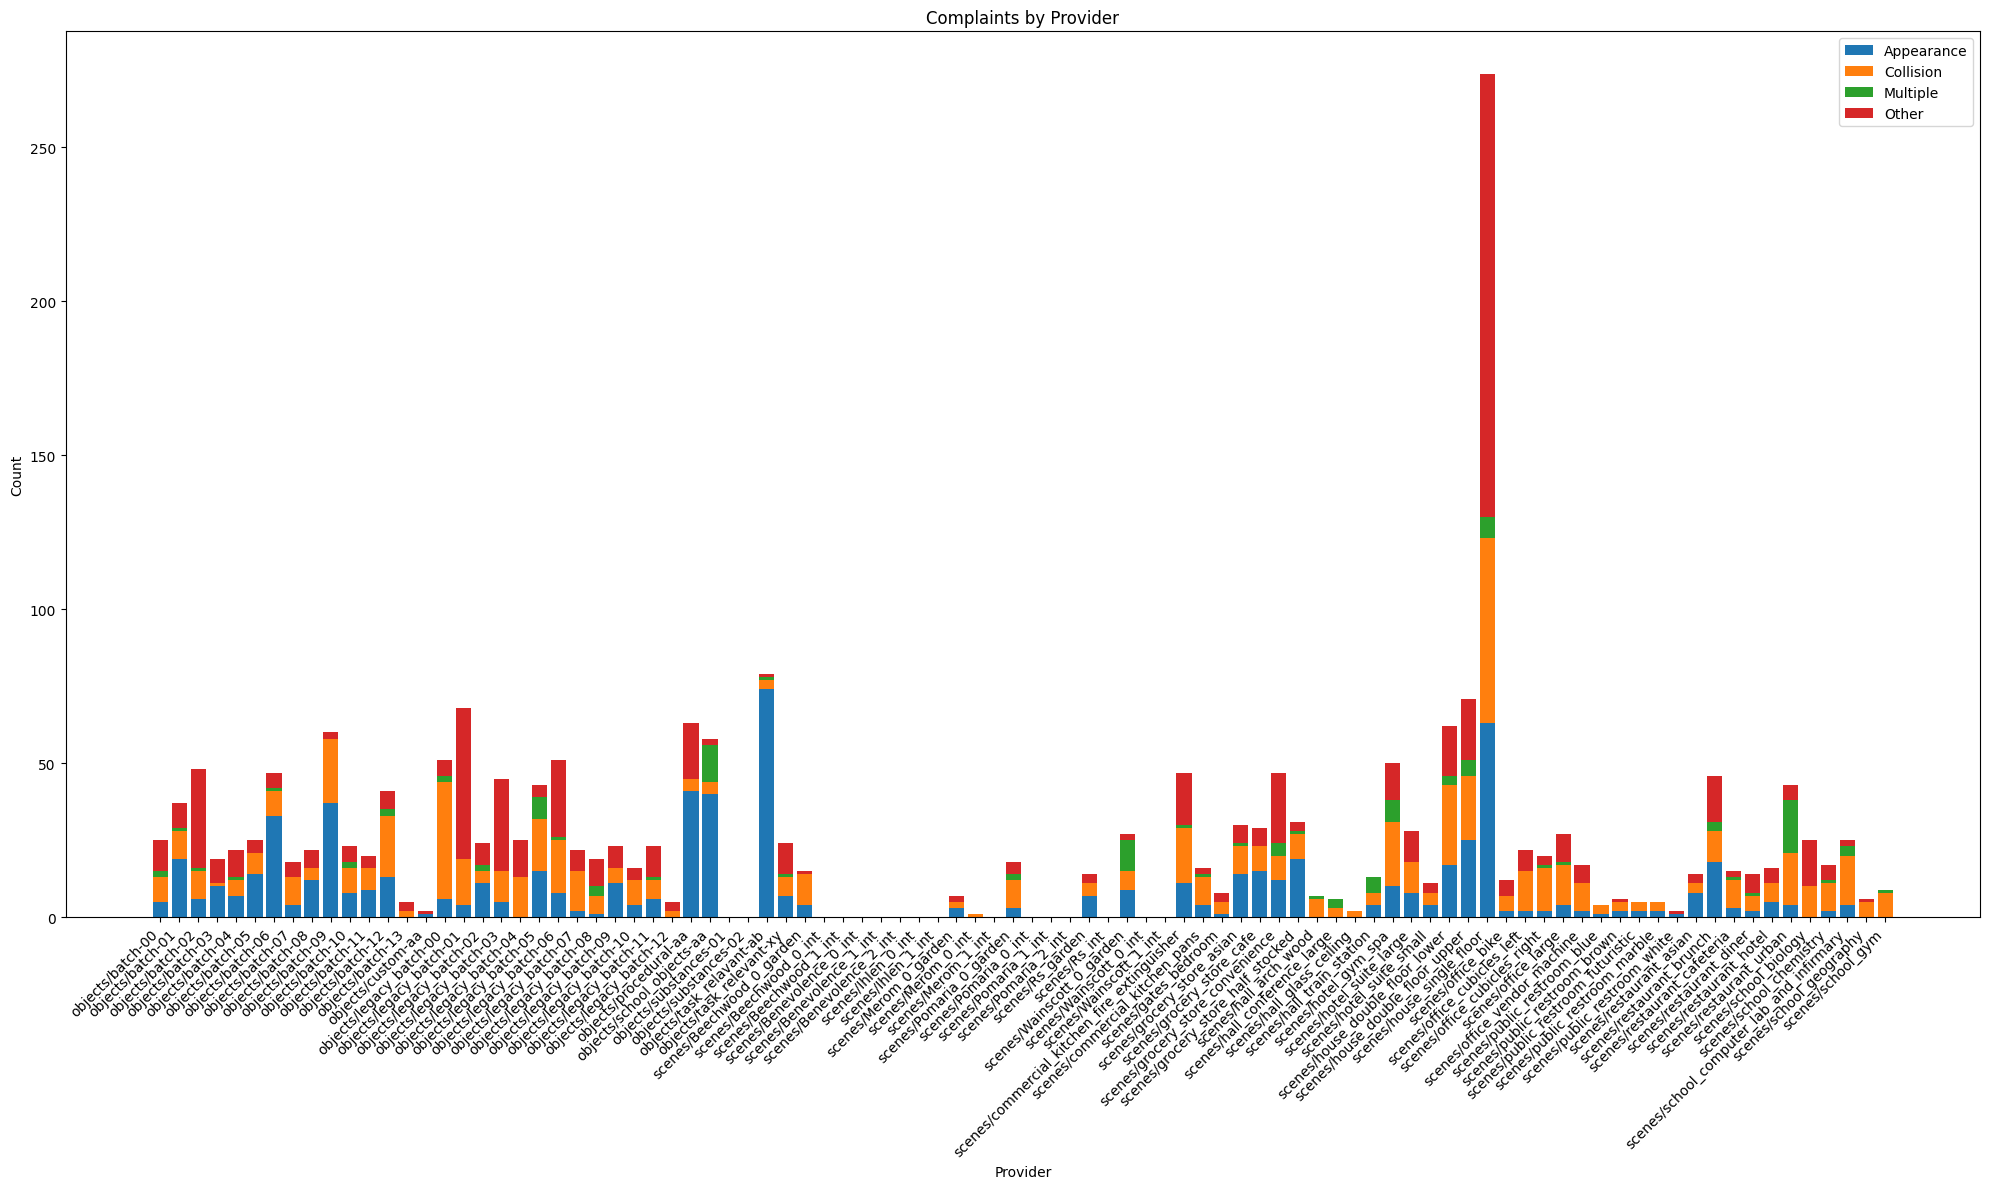

In [29]:
# Plot the provider stats as a bar chart. Each provider should have a single bar that consists of 5 different colored segments.
plt.rcParams["figure.figsize"] = (20, 12)

provider_labels = list(provider_stats.keys())
provider_values = np.array(
  [[v["appearance_complaint_objects"], v["collision_complaint_objects"], v["multiple_complaint_objects"], v["other_complaint_objects"]]
   for v in provider_stats.values()]
)

# Transpose the data for stacking
provider_values = provider_values.T

indexes = np.arange(len(provider_labels))
width = 0.8  # Adjusted width for better visualization

# Plot stacked bars
bar1 = plt.bar(indexes, provider_values[0], width, label="Appearance")
bar2 = plt.bar(indexes, provider_values[1], width, bottom=provider_values[0], label="Collision")
bar3 = plt.bar(indexes, provider_values[2], width, bottom=provider_values[0] + provider_values[1], label="Multiple")
bar4 = plt.bar(indexes, provider_values[3], width, bottom=provider_values[0] + provider_values[1] + provider_values[2], label="Other")

plt.xticks(indexes, provider_labels, rotation=45, ha="right")
plt.legend()
plt.title("Complaints by Provider")
plt.xlabel("Provider")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


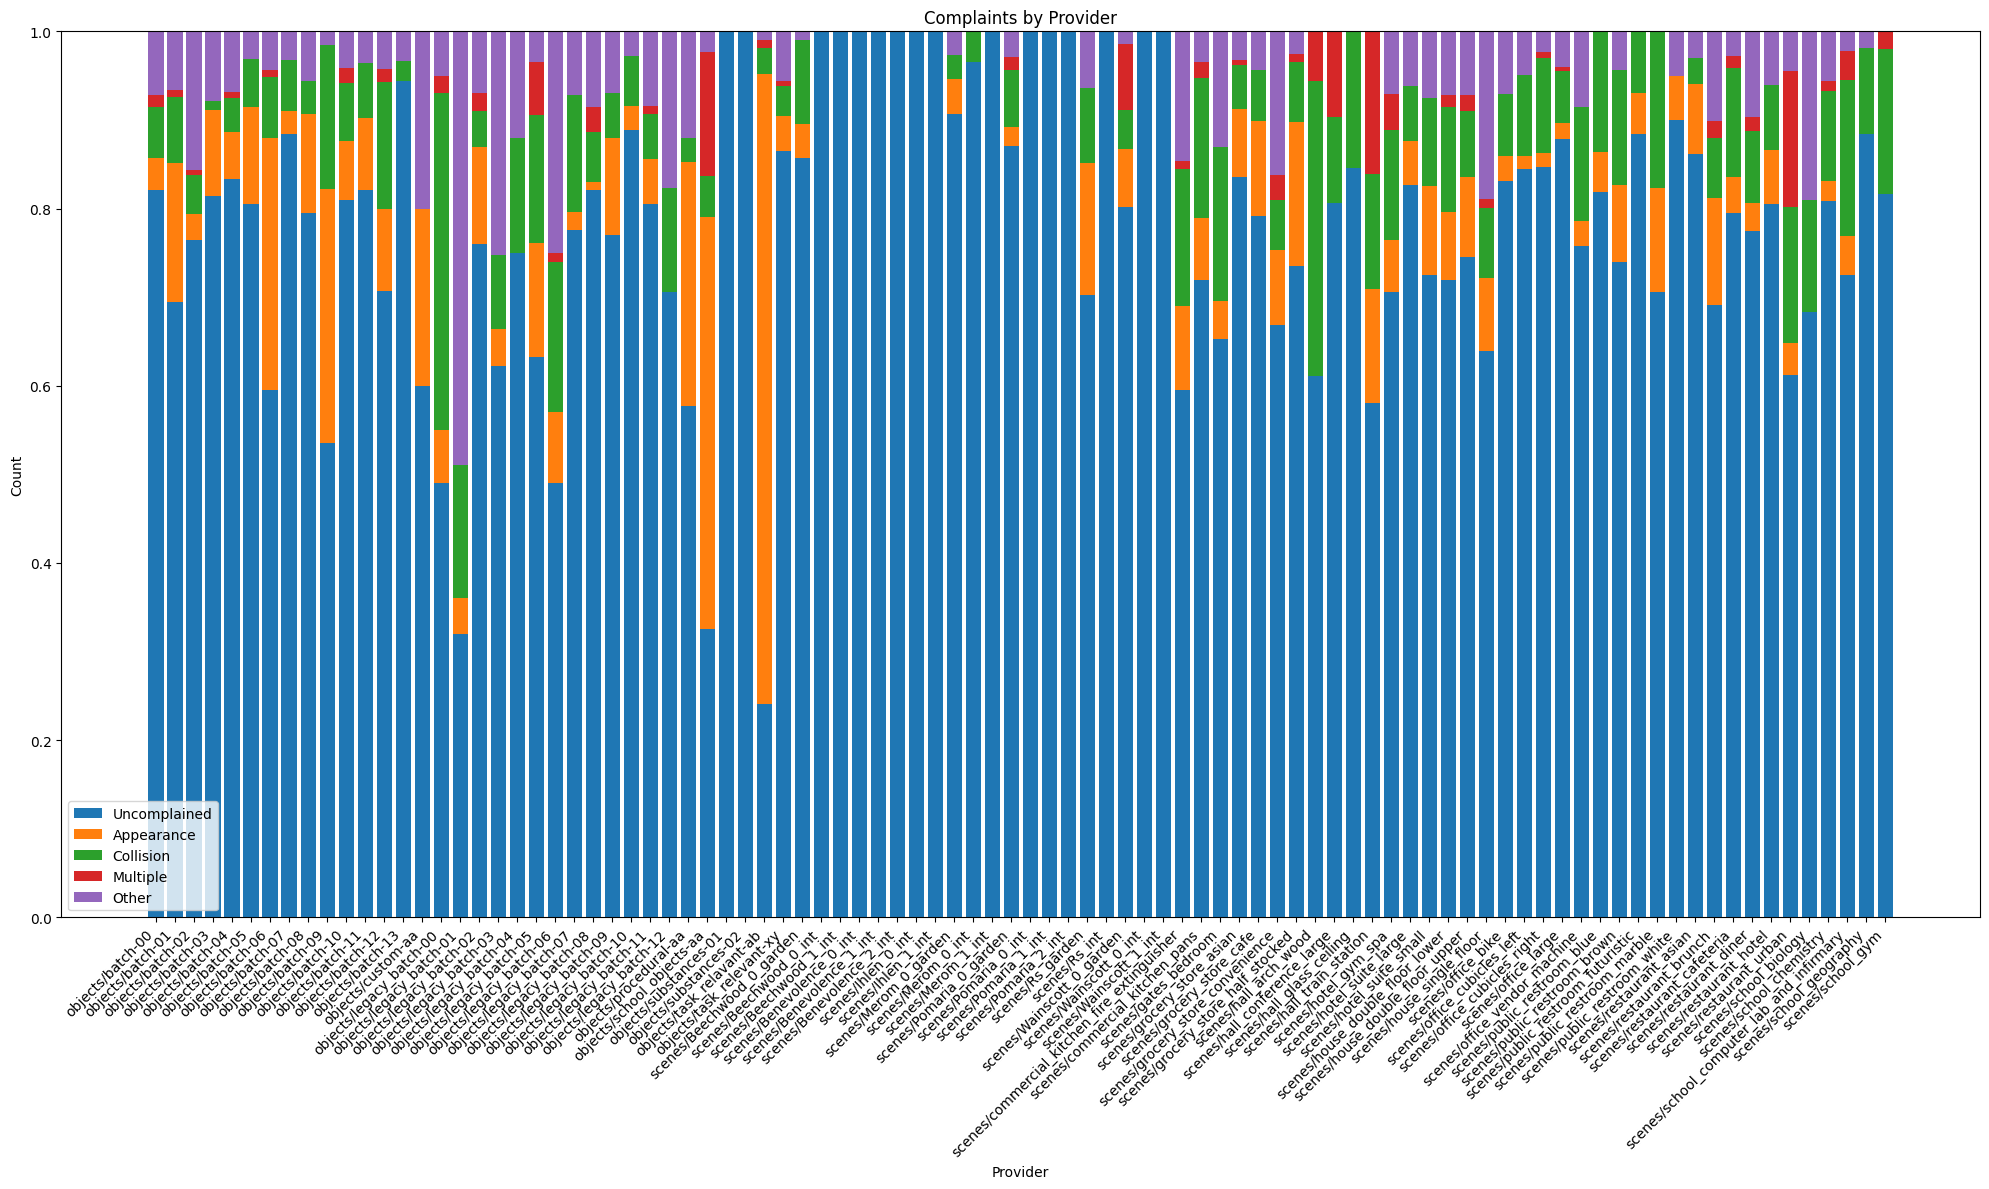

In [27]:
# Plot the NORMALIZED provider stats as a bar chart. Each provider should have a single bar that consists of 5 different colored segments.
plt.rcParams["figure.figsize"] = (20, 12)

provider_labels = list(provider_stats.keys())
provider_values = np.array(
  [[v["uncomplained_objects"], v["appearance_complaint_objects"], v["collision_complaint_objects"], v["multiple_complaint_objects"], v["other_complaint_objects"]]
   for v in provider_stats.values()]
) / np.array([v["total"] for v in provider_stats.values()]).reshape(-1, 1)

# Transpose the data for stacking
provider_values = provider_values.T

indexes = np.arange(len(provider_labels))
width = 0.8  # Adjusted width for better visualization

# Plot stacked bars
bar1 = plt.bar(indexes, provider_values[0], width, label="Uncomplained")
bar2 = plt.bar(indexes, provider_values[1], width, bottom=provider_values[0], label="Appearance")
bar3 = plt.bar(indexes, provider_values[2], width, bottom=provider_values[0] + provider_values[1], label="Collision")
bar4 = plt.bar(indexes, provider_values[3], width, bottom=provider_values[0] + provider_values[1] + provider_values[2], label="Multiple")
bar5 = plt.bar(indexes, provider_values[4], width, bottom=provider_values[0] + provider_values[1] + provider_values[2] + provider_values[3], label="Other")

plt.xticks(indexes, provider_labels, rotation=45, ha="right")
plt.legend()
plt.title("Complaints by Provider")
plt.xlabel("Provider")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

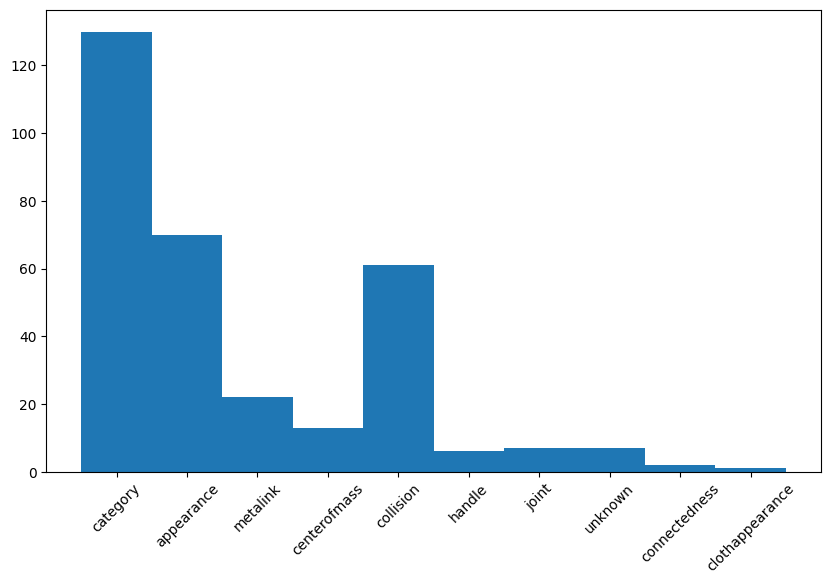

In [33]:
plt.rcParams["figure.figsize"] = (10,6)
# Plot the complaints by type for a specific provider
provider = "scenes/house_single_floor"
provider_objects = objects_by_provider[provider]
provider_complaints_by_type = collections.Counter()
for obj in provider_objects:
    for complaint_type in complaint_types_by_object[obj]:
        provider_complaints_by_type[complaint_type] += 1
labels, values = zip(*[(k, v) for k, v in provider_complaints_by_type.items()])

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=45)
plt.show()

In [34]:
# Review house_single_floor category complaints
for complaint in complaints_by_type["category"]:
  obj_id = complaint["object"].split("-")[-1]
  if obj_id in provider_objects:
    print(complaint)

{'object': 'floor_lamp-disyzd', 'complaint': 'table_lamp', 'processed': False, 'new': True, 'type': 'category', 'additional_info': 'CATEGORY: Confirm object category assignment.\n\nObject assigned to category: floor_lamp\n\nIf the object is not compatible with the rest of the objects in this category,\n(e.g. tabletop sink vs regular sink), change the category here.\nConfirm that the object is the same kind of object as the rest of the objects\nin this category.\n\nIf the category is wrong, please type in the correct category.'}
{'object': 'hamper-otswdv', 'complaint': 'quick complaint added during qa-2025 batch qa-2025-eric', 'processed': False, 'new': True, 'type': 'category', 'additional_info': ''}
{'object': 'lid-kgjkzr', 'complaint': 'quick complaint added during qa-2025 batch qa-2025-eric', 'processed': False, 'new': True, 'type': 'category', 'additional_info': ''}
{'object': 'lid-lkaasa', 'complaint': 'quick complaint added during qa-2025 batch qa-2025-eric', 'processed': False, 

In [35]:
# Save all the appearance complaint objects list
with open("/scr/BEHAVIOR-1K/asset_pipeline/metadata/appearance_complaint_objects.json", "w") as f:
    json.dump(sorted(complained_objects_by_type["appearance"]), f)

In [ ]:
for fn in glob.glob(complaint_glob):
    with open(fn, "r") as f:
        complaints_in_file = json.load(f)
    for c in complaints_in_file:
        if c["type"] == "appearance" and not c["processed"] and c["object"].split("-")[-1] in cloth_appearance_complaint_objects:
            c["type"] = "clothappearance"
    with open(fn, "w") as f:
        json.dump(complaints_in_file, f, indent=4)